### Exercício 1: Ajuste de Parâmetros no DBSCAN em 3D

Com os dados das **três esferas concêntricas**, realize:

1. Plotar o K-Distance para diferentes valores de `min_pts` e sugerir um intervalo adequado para `eps`.
2. Selecionar os melhores parâmetros de `min_pts` e `eps`.
3. Visualizar em 3D os clusters encontrados (cores diferentes) e comentar a escolha de `eps` e `min_samples`.

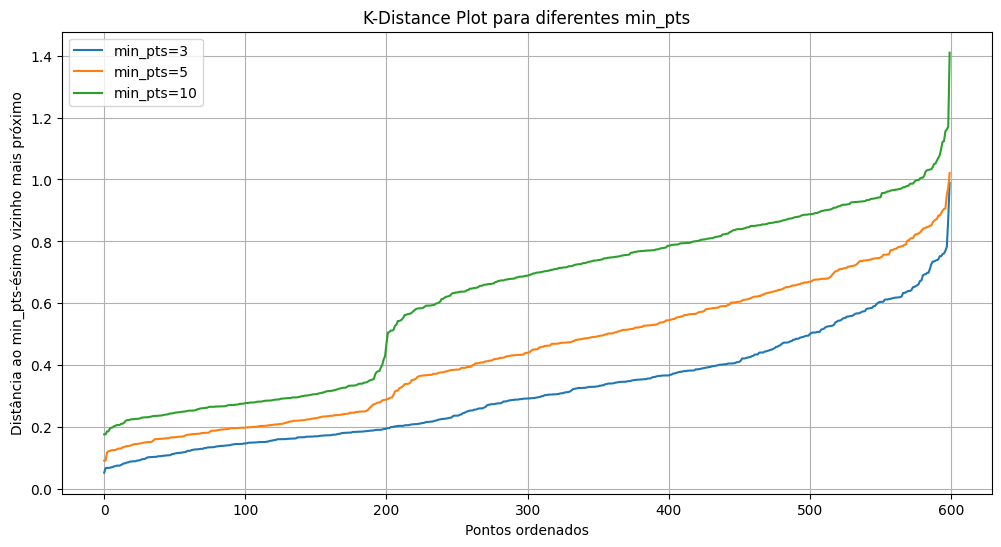

In [10]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import plotly.express as px

# ---------- 1. Gerar esferas concêntricas ----------
def generate_concentric_spheres(radii=[3, 8, 12], n_samples_per_sphere=200, noise=0.4, random_state=42):
    rng = np.random.default_rng(random_state)
    X, y = [], []

    for i, r in enumerate(radii):
        phi = rng.uniform(0, 2*np.pi, n_samples_per_sphere)
        costheta = rng.uniform(-1, 1, n_samples_per_sphere)
        theta = np.arccos(costheta)
        rr = r + noise * rng.standard_normal(n_samples_per_sphere)
        x = rr * np.sin(theta) * np.cos(phi)
        y_ = rr * np.sin(theta) * np.sin(phi)
        z = rr * np.cos(theta)
        X.append(np.vstack((x, y_, z)).T)
        y.append(np.full(n_samples_per_sphere, i))

    X = np.vstack(X)
    y = np.concatenate(y)
    return X, y

X_spheres, y_spheres = generate_concentric_spheres()

# Padronizar
scaler = StandardScaler()
X_spheres_scaled = scaler.fit_transform(X_spheres)

# ---------- 2. K-Distance Plot para diferentes min_pts ----------
min_pts_values = [3, 5, 10]

plt.figure(figsize=(12,6))
for min_pts in min_pts_values:
    nbrs = NearestNeighbors(n_neighbors=min_pts).fit(X_spheres_scaled)
    distances, indices = nbrs.kneighbors(X_spheres_scaled)
    k_distances = np.sort(distances[:, -1])
    plt.plot(k_distances, label=f"min_pts={min_pts}")

plt.xlabel("Pontos ordenados")
plt.ylabel("Distância ao min_pts-ésimo vizinho mais próximo")
plt.title("K-Distance Plot para diferentes min_pts")
plt.legend()
plt.grid(True)
plt.show()

# ---------- 3. Aplicar DBSCAN com parâmetros escolhidos ----------
# Baseado no K-Distance Plot, escolhemos:
best_min_pts = 5
best_eps = 0.8  # exemplo, ajustar conforme o gráfico

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_pts)
clusters = dbscan.fit_predict(X_spheres_scaled)

# Visualização 3D dos clusters
fig = px.scatter_3d(
    x=X_spheres_scaled[:, 0],
    y=X_spheres_scaled[:, 1],
    z=X_spheres_scaled[:, 2],
    color=clusters.astype(str),  # converter para string para cores distintas
    color_discrete_sequence=px.colors.qualitative.Vivid
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(title=f"DBSCAN 3D - eps={best_eps}, min_samples={best_min_pts}")
fig.show()



### Exercício 2: DBSCAN com distância radial

Usando os dados das **3 esferas concêntricas** do exercício anterior:

1. Implemente a **distância radial** e use-a no DBSCAN. A **distância radial** entre dois pontos \(x_i\) e \(x_j\) é a diferença absoluta entre suas distâncias à origem: $d_{\text{radial}}(x_i, x_j) = \big|\;\|x_i\|_2 - \|x_j\|_2\;\big|$
2. Plote o **K-Distance radial** para sugerir `eps`.  
3. Teste combinações de `eps` e `min_samples`.  
4. Visualize em 3D os clusters obtidos e compare com o resultado usando distância euclidiana.  
5. Comente brevemente qual configuração foi melhor e por quê a métrica radial ajuda nesse dataset.

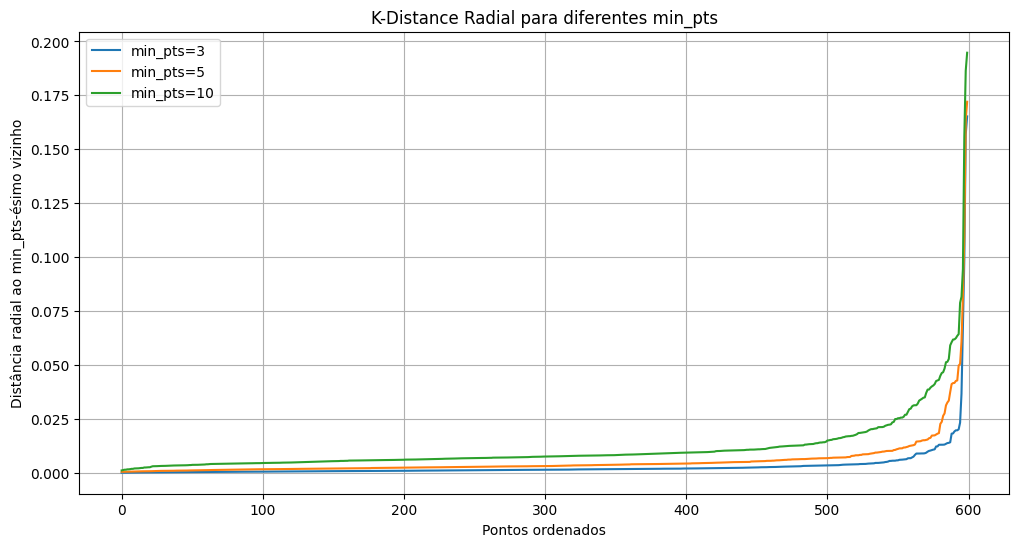

In [11]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import plotly.express as px

# ---------- 1. Distância radial ----------
def radial_distance_matrix(X):
    """
    Calcula a matriz de distância radial:
    d_radial(x_i, x_j) = | ||x_i|| - ||x_j|| |
    """
    norms = np.linalg.norm(X, axis=1)
    dist_matrix = np.abs(norms[:, None] - norms[None, :])
    return dist_matrix

# ---------- 2. K-Distance radial ----------
def plot_k_distance_radial(X_scaled, min_pts_values=[3, 5, 10]):
    plt.figure(figsize=(12,6))
    dist_matrix = radial_distance_matrix(X_scaled)

    for min_pts in min_pts_values:
        # Para cada ponto, pegar a min_pts-ésima menor distância
        k_distances = np.sort(np.partition(dist_matrix, min_pts, axis=1)[:, min_pts-1])
        plt.plot(k_distances, label=f"min_pts={min_pts}")

    plt.xlabel("Pontos ordenados")
    plt.ylabel("Distância radial ao min_pts-ésimo vizinho")
    plt.title("K-Distance Radial para diferentes min_pts")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_k_distance_radial(X_spheres_scaled)

# ---------- 3. Testar DBSCAN com distância radial ----------
# Baseado no gráfico, escolher eps e min_samples
best_eps_radial = 0.5   # ajustar conforme o K-Distance Radial
best_min_samples = 5

# Matriz de distância radial
dist_matrix_radial = radial_distance_matrix(X_spheres_scaled)

# DBSCAN usando pré-computed distance
dbscan_radial = DBSCAN(eps=best_eps_radial, min_samples=best_min_samples, metric='precomputed')
clusters_radial = dbscan_radial.fit_predict(dist_matrix_radial)

# ---------- 4. Visualização 3D ----------
fig = px.scatter_3d(
    x=X_spheres_scaled[:, 0],
    y=X_spheres_scaled[:, 1],
    z=X_spheres_scaled[:, 2],
    color=clusters_radial.astype(str),
    color_discrete_sequence=px.colors.qualitative.Vivid
)
fig.update_traces(marker=dict(size=4))
fig.update_layout(title=f"DBSCAN 3D com Distância Radial - eps={best_eps_radial}, min_samples={best_min_samples}")
fig.show()

# ---------- 5. Comparação com distância euclidiana ----------
# DBSCAN Euclidiano para referência
dbscan_euc = DBSCAN(eps=0.8, min_samples=5)
clusters_euc = dbscan_euc.fit_predict(X_spheres_scaled)

fig2 = px.scatter_3d(
    x=X_spheres_scaled[:, 0],
    y=X_spheres_scaled[:, 1],
    z=X_spheres_scaled[:, 2],
    color=clusters_euc.astype(str),
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig2.update_traces(marker=dict(size=4))
fig2.update_layout(title="DBSCAN 3D com Distância Euclidiana")
fig2.show()


## Exercício 3: Detecção de Anomalias com DBSCAN e DTW
O DTW (Dynamic Time Warping) mede a similaridade entre séries temporais mesmo quando estão defasadas ou com velocidades diferentes, alinhando-as de forma elástica. Isso permite detectar padrões semelhantes sem que a defasagem atrapalhe.

Pode ser calculado por:

from dtaidistance import dtw

n = len(X)              # número de séries
D = np.zeros((n, n))    # matriz de distâncias

for i in range(n):
    for j in range(i+1, n):
        dist = dtw.distance_fast(X[i], X[j])  # distância DTW
        D[i, j] = D[j, i] = dist              # matriz simétrica
Tarefas:

Use o dataset de senóides com variação e anomalias simuladas.
Adicione a métrica DTW no DBSCAN.
Experimente diferentes valores de eps e min_samples até que o modelo consiga separar bem séries normais das anômalas.
Plote todas as séries, usando uma cor para as normais e outra para as anomalias detectadas (label = -1).

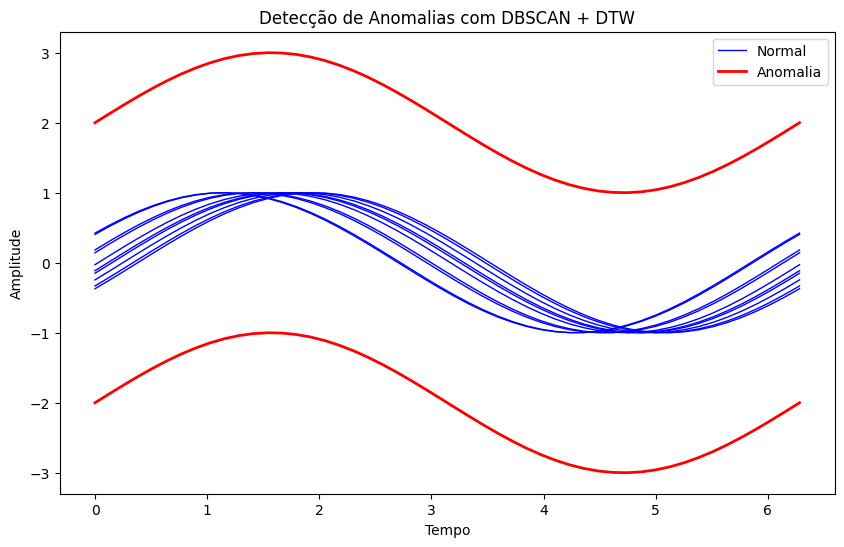

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# ---------- 1. Simular séries temporais ----------
# Exemplo: 10 séries "normais" + 2 anômalas
n_series = 12
t = np.linspace(0, 2*np.pi, 50)

X = []
for i in range(10):
    X.append(np.sin(t + np.random.uniform(-0.5, 0.5)))  # normais
X.append(np.sin(t) + 2)  # anomalia
X.append(np.sin(t) - 2)  # anomalia

X = np.array(X)

# ---------- 2. Função DTW simples ----------
def dtw_distance(s1, s2):
    n, m = len(s1), len(s2)
    dtw_matrix = np.full((n+1, m+1), np.inf)
    dtw_matrix[0,0] = 0

    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(s1[i-1] - s2[j-1])
            dtw_matrix[i,j] = cost + min(
                dtw_matrix[i-1, j],    # inserção
                dtw_matrix[i, j-1],    # deleção
                dtw_matrix[i-1, j-1]   # match
            )
    return dtw_matrix[n, m]

# ---------- 3. Criar matriz de distâncias DTW ----------
n = len(X)
D = np.zeros((n, n))
for i in range(n):
    for j in range(i+1, n):
        dist = dtw_distance(X[i], X[j])
        D[i,j] = D[j,i] = dist

# ---------- 4. DBSCAN com matriz de distâncias ----------
# Ajuste eps e min_samples conforme necessário
db = DBSCAN(eps=5, min_samples=2, metric='precomputed')
labels = db.fit_predict(D)

# ---------- 5. Visualizar séries ----------
plt.figure(figsize=(10,6))
for i in range(n):
    if labels[i] == -1:
        plt.plot(t, X[i], c='r', lw=2, label='Anomalia' if i==10 else "")
    else:
        plt.plot(t, X[i], c='b', lw=1, label='Normal' if i==0 else "")
plt.legend()
plt.title("Detecção de Anomalias com DBSCAN + DTW")
plt.xlabel("Tempo")
plt.ylabel("Amplitude")
plt.show()
